In [1]:
# !pip3 install scikit-learn torch seaborn latex

In [2]:
from datetime import datetime

import numpy as np
# import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    logistic_sparse_reward_function,
    linear_reward_function
)
from obp.policy import IPWLearner, LogisticTS, Random
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    InverseProbabilityWeightingOptimalBaseline,
    SelfNormalizedInverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)
from obp.utils import estimate_confidence_interval_by_bootstrap

from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression

from tqdm.notebook import tqdm



In [3]:
'Starting'

'Starting'

In [4]:
def slice_data(data, N):
    return {
        'n_rounds': N,
        'n_actions': data['n_actions'],
        'context': data['context'][:N,:],
        'action_context': data['action_context'],
        'action': data['action'][:N],
        'position': data['position'],
        'reward': data['reward'][:N],
        'expected_reward': data['expected_reward'][:N,:],
        'pi_b': data['pi_b'][:N,:,:],
        'pscore': data['pscore'][:N],
    }

In [ ]:
from collections import defaultdict

train_N = 2048
As = [20]
As = [10]
betas = [-1.5]

ope_estimators = [InverseProbabilityWeighting(),SelfNormalizedInverseProbabilityWeighting(), InverseProbabilityWeightingOptimalBaseline()]


test_Ns = np.logspace(2.3,6,26).astype(int)

estimator2N2CIs = defaultdict(lambda: defaultdict(list))

logging_truth = []
target_truth = []

dim_context = 10

for A in As:
    for beta in betas:
        dataset = SyntheticBanditDataset(
            n_actions=A,
            dim_context=dim_context,
            beta=beta, 
            reward_type="binary", 
            reward_function=logistic_sparse_reward_function,
            random_state=0,
        )
        # Train
        bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=int(train_N))

        target_policy = LogisticTS(dim=dim_context, n_actions=A, batch_size=int(train_N), alpha_=1.0, lambda_=1e-3)
        for action, reward, context in zip(bandit_feedback_train["action"], bandit_feedback_train["reward"], bandit_feedback_train["context"]):
            target_policy.update_params(
                action=action,
                reward=reward,
                context=context,
            )
        # Test
        print(datetime.now(), 'Generating test data...')
        bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=int(test_Ns[-1]))
        print(datetime.now(), 'Generating predictions on test data...')
        #target_policy_output = target_policy.predict(context=bandit_feedback_test["context"])
        target_policy_output = target_policy.predict(context=bandit_feedback_test["context"], monte_carlo=False)
        target_policy_output /= target_policy_output.sum(axis=1, keepdims=True) # Rounding errors
        print(datetime.now(), 'Evaluating predictions on test data...')
        for test_N in tqdm(test_Ns):

            ope = OffPolicyEvaluation(
                bandit_feedback=slice_data(bandit_feedback_test, test_N),
                ope_estimators=ope_estimators
            )

            # For every estimator
            for estimator_name, estimator in ope.ope_estimators_.items():
                Vhat_pi_theta_mu = estimator.estimate_policy_value(**ope._create_estimator_inputs(action_dist=target_policy_output[:test_N])[estimator_name])
                Vhat_pi_theta_var = estimator.estimate_variance(**ope._create_estimator_inputs(action_dist=target_policy_output[:test_N])[estimator_name])

                ci_width = 2.567 * np.sqrt(Vhat_pi_theta_var / test_N) if estimator_name != 'snipw' else 2.567 * np.sqrt(Vhat_pi_theta_var)

                estimator_CI = {
                    '95.0% CI (lower)': Vhat_pi_theta_mu - ci_width,
                    'mean': Vhat_pi_theta_mu,
                    '95.0% CI (upper)': Vhat_pi_theta_mu + ci_width
                }
                estimator2N2CIs[estimator_name][test_N].append(estimator_CI)

        print(datetime.now(), 'Obtaining ground truth data...')
        # Ground truth calculation
        ground_truth_data= dataset.obtain_batch_bandit_feedback(n_rounds=int(5e5))
        print(datetime.now(), 'Evaluating on ground truth data...')
        V_pi_theta = dataset.calc_ground_truth_policy_value(
                expected_reward=ground_truth_data["expected_reward"],
                action_dist=target_policy.predict(context=ground_truth_data["context"], monte_carlo=True),
        )
        print(datetime.now(), 'Evaluating logging policy...')
        logging_truth.append(np.mean(ground_truth_data["reward"]))
        target_truth.append(V_pi_theta)

print(datetime.now(), '... done!')

2025-03-25 15:08:55.192398 Generating test data...
2025-03-25 15:08:56.888241 Generating predictions on test data...


100%|██████████| 316227/316227 [35:32<00:00, 148.26it/s]


2025-03-25 15:44:31.093402 Evaluating predictions on test data...


  0%|          | 0/26 [00:00<?, ?it/s]

2025-03-25 15:44:31.215452 Obtaining ground truth data...
2025-03-25 15:44:32.947677 Evaluating on ground truth data...
2025-03-25 15:46:11.988267 Evaluating logging policy...
2025-03-25 15:46:11.989987 ... done!


In [16]:
for e, N2CI in estimator2N2CIs.items():
    print(e)
    for N, CI in N2CI.items():
        print('\t', N, CI)

ipw
	 199 [{'95.0% CI (lower)': 0.08616695264377017, 'mean': 0.439919955295951, '95.0% CI (upper)': 0.7936729579481319}]
	 267 [{'95.0% CI (lower)': 0.09262364159249437, 'mean': 0.38671172207189997, '95.0% CI (upper)': 0.6807998025513056}]
	 359 [{'95.0% CI (lower)': 0.1500378843041238, 'mean': 0.4931241399860716, '95.0% CI (upper)': 0.8362103956680194}]
	 483 [{'95.0% CI (lower)': 0.17745013904010642, 'mean': 0.44309631741311617, '95.0% CI (upper)': 0.7087424957861259}]
	 648 [{'95.0% CI (lower)': 0.21626559067243528, 'mean': 0.44894622615414553, '95.0% CI (upper)': 0.6816268616358558}]
	 870 [{'95.0% CI (lower)': 0.2443541268677639, 'mean': 0.4411331343219844, '95.0% CI (upper)': 0.6379121417762049}]
	 1169 [{'95.0% CI (lower)': 0.2722429406429253, 'mean': 0.4340019546792441, '95.0% CI (upper)': 0.5957609687155628}]
	 1570 [{'95.0% CI (lower)': 0.27874928380560277, 'mean': 0.4098420480179259, '95.0% CI (upper)': 0.5409348122302491}]
	 2108 [{'95.0% CI (lower)': 0.334178890277384, 'me

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': True,
    'svg.fonttype': 'none',
    'font.family': 'Linux Libertine',
    'text.latex.preamble': r'\usepackage{libertine}',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'libertine',
    'mathtext.it': 'libertine:italic',
    'mathtext.bf': 'libertine:bold'
    }
mpl.rcParams.update(new_rc_params)
plt.style.use('tableau-colorblind10')
plt.rc('axes', axisbelow=True)

In [18]:
# Taken from
# https://gist.github.com/AndiH/c957b4d769e628f506bd

# Tableau 20 Colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

In [19]:
estimator2colour = {
    'ipw': tableau20[0],
    'ipwob': tableau20[4],
    'snipw': tableau20[2],
    'Delta-ipw': tableau20[1],
    'Delta-snipw': tableau20[3],
    'Delta-ipwob': tableau20[5]
}
estimator2label = {
    'ipw': r'$\widehat{V}_{\rm IPS}$',
    'ipwob': r'$\widehat{V}_{{\beta}{\rm -IPS}}$',
    'snipw': r'$\widehat{V}_{\rm SNIPS}$',
    'Delta-ipw': r'$\widehat{V}_{{\Delta}{\rm -IPS}}$',
    'Delta-snipw': r'$\widehat{V}_{{\Delta}{\rm -SNIPS}}$',
    'Delta-ipwob': r'$\widehat{V}_{{\Delta\beta}{\rm -IPS}}$'
}
estimator2marker = {
    'ipw': 's',
    'Delta-ipw': 'D',
    'snipw': 'v',
    'Delta-snipw': '^',
    'ipwob': 'x',
    'Delta-ipwob': '+'
}

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) 

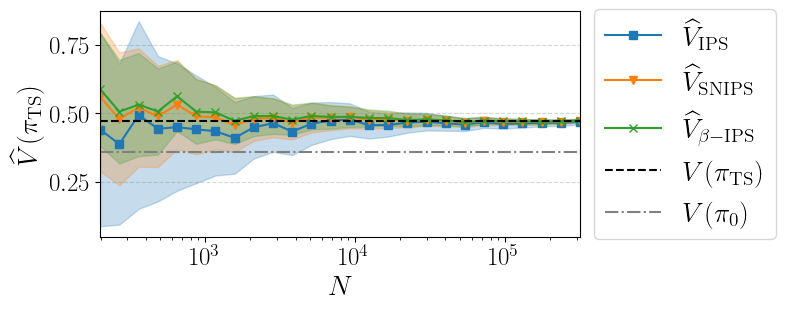

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(6, 3.2))
fontsize=22

for e, N2CI in estimator2N2CIs.items():
    x = np.asarray(list(N2CI.keys()))
    y = np.asarray([N2CI[N][0]['mean'] for N in x])
    ax.plot(x,y,label=estimator2label[e], color=estimator2colour[e], marker=estimator2marker[e])

    y_lo = np.asarray([N2CI[N][0]['95.0% CI (lower)'] for N in x])
    y_hi = np.asarray([N2CI[N][0]['95.0% CI (upper)'] for N in x])

    ax.fill_between(x,y_lo, y_hi, alpha=.25, color=estimator2colour[e])

ax.axhline(target_truth[0], label=r'$V(\pi_{\rm TS})$', color='black', linestyle='--')
ax.axhline(logging_truth[0], label=r'$V(\pi_0)$', color='gray', linestyle='-.')


ax.set_xscale('log')

ax.set_xlabel(r'$N$', fontsize=fontsize-2)
ax.set_ylabel(r'$\widehat{V}(\pi_{\rm TS})$', fontsize=fontsize-2)

ax.grid(axis='y', which='both', ls='--', alpha=.5)

ax.set_xlim(x.min(), x.max())

ax.xaxis.set_tick_params(labelsize=fontsize-4)            
ax.yaxis.set_tick_params(labelsize=fontsize-4)

fig.tight_layout()
ax.legend(fontsize=fontsize-2, ncol=1, loc='upper left', bbox_to_anchor=(1.0,1.07))

plt.savefig('OPE_TS.pdf', bbox_inches='tight')
plt.show()

In [21]:
# !brew install texlive-latex-extra texlive-fonts-recommended dvipng cm-super